In [20]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Flatten, Reshape, Dense, Dropout, Activation, Lambda
from keras.utils import to_categorical
from sklearn.utils import shuffle

In [21]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)

In [22]:
num_labeled = 500
labeled_indices = np.random.choice(x_train.shape[0], num_labeled, replace=False)
x_labeled = x_train[labeled_indices]
y_labeled = y_train[labeled_indices]

# Create a set of unlabeled data
unlabeled_indices = np.setdiff1d(np.arange(x_train.shape[0]), labeled_indices)
x_unlabeled = x_train[unlabeled_indices]


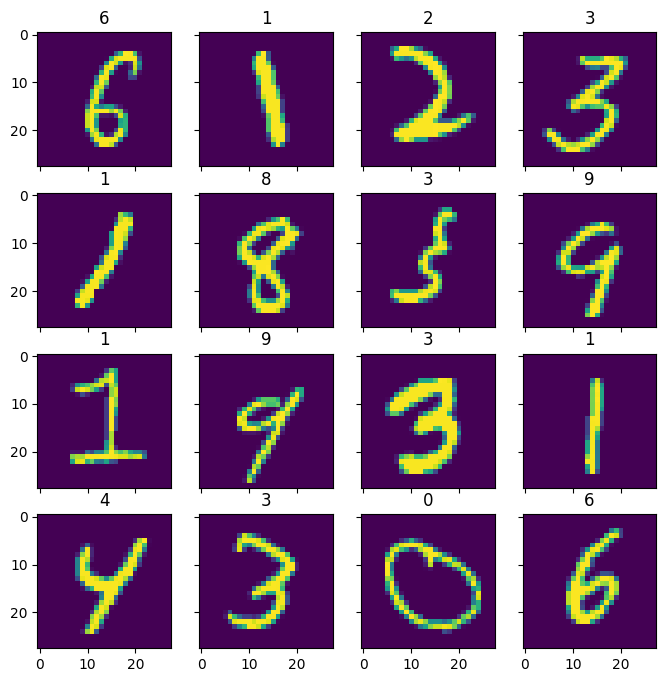

In [23]:
def show(X, y=None, r=4, c=4):
  fig, ax = plt.subplots(r, c, squeeze=True, sharex=True, sharey=True, figsize=(8, 8))
  for i in range(r):
    for j in range(c):
      ax[i][j].imshow(X[i*c + j, :, :, 0])
      if y is not None:
        ax[i][j].set_title(str(y[i*c + j]))
  plt.show()
show(x_labeled,y_labeled)

In [24]:
def buildDisc(img_shape=(28, 28, 1), k=10):
  model = Sequential()
  model.add(Conv2D(32, 3, 2, 'same', input_shape=img_shape))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.01))

  model.add(Conv2D(64, 3, 2, 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.01))

  model.add(Conv2D(128, 3, 2, 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.01))

  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(k))

  return model

In [25]:
def buildSupervisedDisc(disc):
  model = Sequential()
  model.add(disc)
  model.add(Activation('softmax'))
  return model

def buildUnsupervisedDisc(disc):
  model = Sequential()
  model.add(disc)

  def predict(x):
    p = 1. - 1./(tf.reduce_sum(tf.exp(x), axis=-1, keepdims=True) + 1.)
    return p

  model.add(Lambda(predict))
  return model

In [26]:
def buildGen(z_dim=100):
  model = Sequential()
  model.add(Dense(7*7*256, input_shape=(z_dim,)))
  model.add(BatchNormalization())
  model.add(Reshape((7, 7, 256)))

  model.add(Conv2DTranspose(128, 3, 2, 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.01))

  model.add(Conv2DTranspose(64, 3, 2, 'same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.01))

  model.add(Conv2DTranspose(1, 3, 1, 'same', activation='tanh'))
  return model

In [27]:
def buildGan(generator, discriminator):
    model = Sequential([
        generator,
        discriminator
    ])
    return model

In [28]:
disc = buildDisc()
disc_sup = buildSupervisedDisc(disc)
disc_unsup = buildUnsupervisedDisc(disc)
disc_sup.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
disc_unsup.compile(optimizer='adam', loss='bce', metrics=['acc'])

In [29]:
generator = buildGen()

In [30]:
disc_unsup.trainable = False
gan=buildGan(generator,disc_unsup)
gan.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [31]:
batch_size = 64
epochs = 1000
sample_interval = 100

In [32]:
def train_gan(generator, disc_sup,disc_unsup, combined, x_labeled, y_labeled, x_unlabeled):
    for epoch in range(epochs):
        # Train Discriminator on labeled data
        idx = np.random.randint(0, x_labeled.shape[0], batch_size)
        x_real_labeled = x_labeled[idx]
        y_real_labeled = y_labeled[idx]

        d_loss_real = disc_sup.train_on_batch(x_real_labeled, y_real_labeled)

        # Train Discriminator on unlabeled data
        idx = np.random.randint(0, x_unlabeled.shape[0], batch_size)
        x_real_unlabeled = x_unlabeled[idx]

        noise = np.random.randn(batch_size, 100)
        x_fake = generator.predict(noise)
        y_fake = np.zeros((batch_size, 1))  # Label 10 for fake data

        x_combined_unlabeled = np.concatenate([x_real_unlabeled, x_fake])
        y_combined_unlabeled = np.concatenate([np.ones((batch_size, 1)), y_fake])  # Label 10 for all combined data

        d_loss_fake = disc_unsup.train_on_batch(x_combined_unlabeled, y_combined_unlabeled)

        d_loss,d_acc = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.randn(batch_size, 100)
        y_gen = np.ones((batch_size, 1))  # Fake label for generated data
        g_loss = combined.train_on_batch(noise, y_gen)

        # Print progress
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss} | D accuracy: {100*d_acc}] [G loss: {g_loss[0]}]")

In [ ]:
train_gan(generator,disc_sup,disc_unsup , gan, x_labeled, y_labeled, x_unlabeled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
0 [D loss: 1.7752045392990112 | D accuracy: 28.125] [G loss: 1.2464628219604492]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━

In [1]:
def evaluate_discriminator(discriminator, x_test, y_test):
    loss, accuracy = discriminator.evaluate(x_test, y_test)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

In [2]:
x_test = np.expand_dims(x_test, axis=-1)  # Add channel dimension if not already added

NameError: name 'np' is not defined

In [ ]:
evaluate_discriminator(disc_sup, x_test, y_test)